# Transaction Anomaly Detection Model

## Isolation Forest for Real-Time Transaction Monitoring

This notebook documents the modeling process for detecting anomalies in transaction data.
The goal is to identify when **denied**, **failed**, or **reversed** transaction rates exceed
normal patterns, triggering alerts for the monitoring service.

### Approach
- **Model**: Isolation Forest (unsupervised anomaly detection)
- **Features**: Per-status rolling statistics (mean, std, z-score) across multiple time windows
- **Severity Levels**: NORMAL → WARNING → CRITICAL based on anomaly score + z-score thresholds
- **Integration**: Model is serialized and loaded by the monitoring API for real-time inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 5)

DATA_DIR = Path("../../sample_data/transactions")
print("Data directory:", DATA_DIR.resolve())

Data directory: C:\Users\David\Documents\learning_repos\cw_monitoring_test\sample_data\transactions


## 1. Data Loading & Exploration

Load the transaction data and examine the status distribution across the 72-hour window.

In [2]:
# Load transaction data
df = pd.read_csv(DATA_DIR / "transactions.csv", parse_dates=["timestamp"])
df_auth = pd.read_csv(DATA_DIR / "transactions_auth_codes.csv", parse_dates=["timestamp"])

print(f"Transactions: {len(df)} rows, {df['status'].nunique()} statuses")
print(f"Auth codes:   {len(df_auth)} rows, {df_auth['auth_code'].nunique()} codes")
print(f"\nTime range: {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"\nStatuses: {sorted(df['status'].unique())}")
print(f"\nPer-status summary:")
df.groupby("status")["count"].describe().round(2)

Transactions: 25920 rows, 6 statuses
Auth codes:   12960 rows, 3 codes

Time range: 2025-07-12 13:45:00 → 2025-07-15 13:44:00

Statuses: ['approved', 'backend_reversed', 'denied', 'failed', 'refunded', 'reversed']

Per-status summary:


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,4320.0,116.81,14.22,57.0,110.0,118.0,126.0,155.0
backend_reversed,4320.0,0.19,0.86,0.0,0.0,0.0,0.0,9.0
denied,4320.0,6.93,5.34,0.0,4.0,6.0,8.0,58.0
failed,4320.0,0.06,0.48,0.0,0.0,0.0,0.0,10.0
refunded,4320.0,1.02,1.00,0.0,0.0,1.0,2.0,8.0
reversed,4320.0,0.98,1.00,0.0,0.0,1.0,2.0,7.0


In [3]:
# Pivot: one row per minute, one column per status
pivoted = df.pivot_table(index="timestamp", columns="status", values="count", fill_value=0)
pivoted = pivoted.sort_index()

print(f"Pivoted shape: {pivoted.shape} (minutes × statuses)")
pivoted.head(10)

Pivoted shape: (4320, 6) (minutes × statuses)


status,approved,backend_reversed,denied,failed,refunded,reversed
timestamp,,,,,,
2025-07-12 13:45:00,116.0,0.0,5.0,0.0,1.0,4.0
2025-07-12 13:46:00,128.0,0.0,1.0,0.0,0.0,2.0
2025-07-12 13:47:00,107.0,0.0,3.0,0.0,2.0,1.0
2025-07-12 13:48:00,123.0,0.0,3.0,0.0,0.0,4.0
2025-07-12 13:49:00,132.0,0.0,4.0,0.0,3.0,0.0
2025-07-12 13:50:00,109.0,0.0,9.0,0.0,0.0,1.0
2025-07-12 13:51:00,113.0,0.0,5.0,0.0,1.0,1.0
2025-07-12 13:52:00,118.0,0.0,0.0,0.0,0.0,1.0
2025-07-12 13:53:00,124.0,0.0,11.0,0.0,0.0,0.0


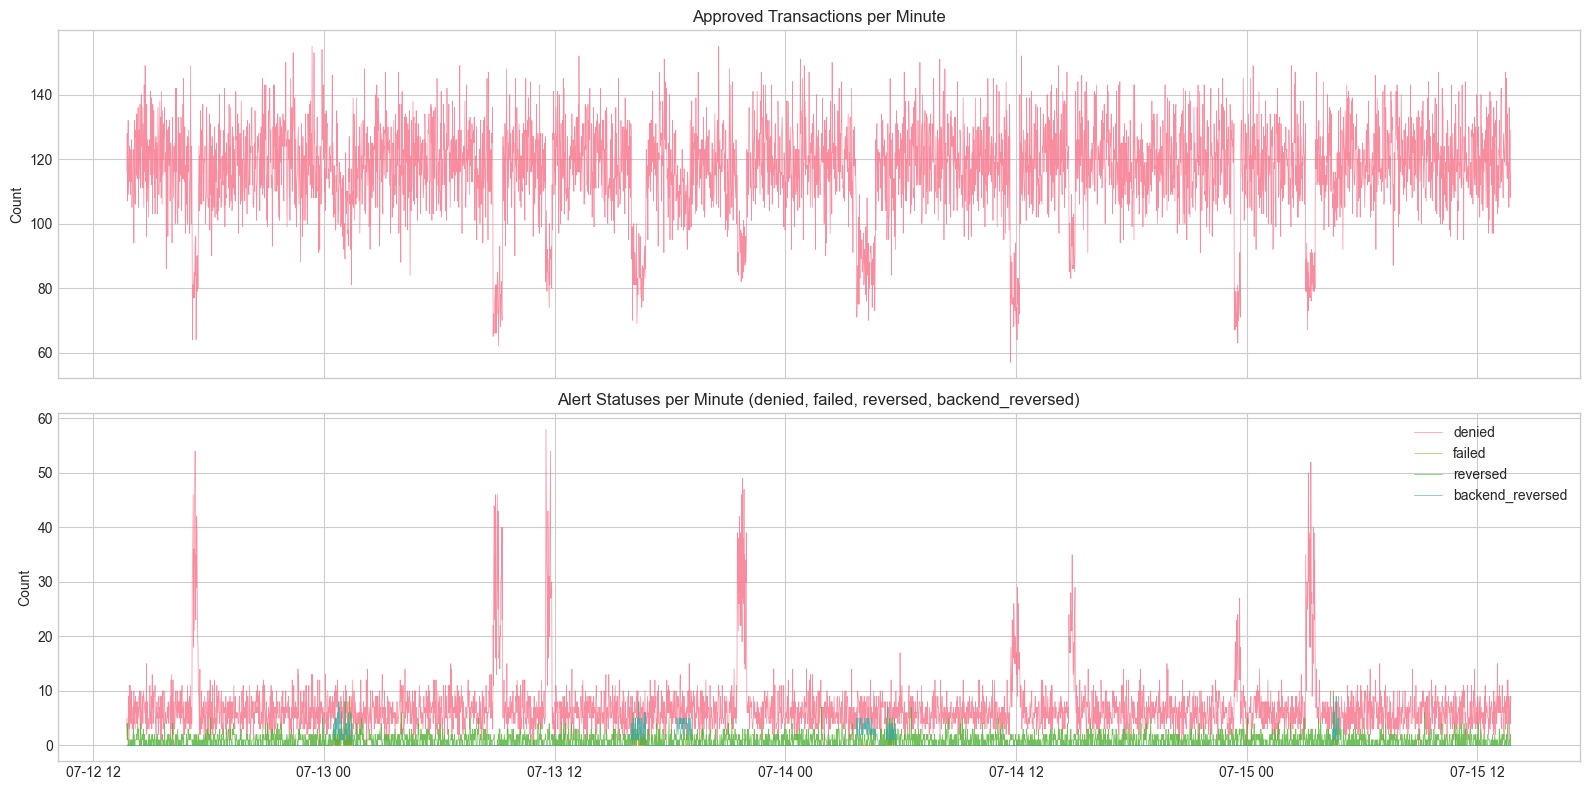

In [4]:
# Visualize status trends over time
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Approved volume (high traffic)
axes[0].plot(pivoted.index, pivoted["approved"], alpha=0.8, linewidth=0.5)
axes[0].set_title("Approved Transactions per Minute")
axes[0].set_ylabel("Count")

# Alert statuses (lower volume — the ones we monitor)
for status in ["denied", "failed", "reversed", "backend_reversed"]:
    if status in pivoted.columns:
        axes[1].plot(pivoted.index, pivoted[status], label=status, alpha=0.8, linewidth=0.5)
axes[1].set_title("Alert Statuses per Minute (denied, failed, reversed, backend_reversed)")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()

## 2. Baseline Statistics

Compute per-status baselines that define "normal" behaviour. These baselines also define the thresholds for rule-based alerting.

In [5]:
# Compute baseline statistics per status
alert_statuses = ["denied", "failed", "reversed", "backend_reversed"]

baselines = {}
for status in alert_statuses:
    vals = pivoted[status].values
    baselines[status] = {
        "mean": np.mean(vals),
        "std": np.std(vals),
        "median": np.median(vals),
        "p95": np.percentile(vals, 95),
        "p99": np.percentile(vals, 99),
        "max": np.max(vals),
    }

baseline_df = pd.DataFrame(baselines).T.round(3)
print("Baseline statistics per alert status (per minute):")
baseline_df

Baseline statistics per alert status (per minute):


,mean,std,median,p95,p99,max
denied,6.934,5.340,6.0,13.0,35.0,58.0
failed,0.062,0.476,0.0,0.0,2.0,10.0
reversed,0.982,1.001,1.0,3.0,4.0,7.0
backend_reversed,0.191,0.855,0.0,1.0,5.0,9.0


## 3. Feature Engineering

For each minute, we compute features that capture both the current state and its deviation from recent history:

- **Current count** per alert status
- **Ratio to total** transactions (denied/total, etc.)
- **Rolling mean/std/z-score** over 5m, 15m, 60m windows
- **Global features**: total count, approval rate

This gives the Isolation Forest a rich view of "normalcy" to learn from.

In [6]:
from anomaly_model.model import _engineer_features, _get_feature_names, ALERT_STATUSES, ROLLING_WINDOWS

# Convert pivoted DataFrame to list of dicts (our model's input format)
all_statuses = list(pivoted.columns)
history_dicts = []
for _, row in pivoted.iterrows():
    history_dicts.append({s: int(row[s]) for s in all_statuses})

# Build feature matrix using sliding windows
WINDOW = 60
feature_rows = []
for i in range(WINDOW, len(history_dicts)):
    current = history_dicts[i]
    hist = history_dicts[i - WINDOW:i]
    features = _engineer_features(current, hist)
    feature_rows.append(features[0])

X = np.array(feature_rows)
feature_names = _get_feature_names()

print(f"Feature matrix: {X.shape[0]} samples × {X.shape[1]} features")
print(f"\nFeature names:\n{feature_names}")

Feature matrix: 4260 samples × 46 features

Feature names:
['denied_count', 'denied_ratio', 'denied_mean_5m', 'denied_std_5m', 'denied_zscore_5m', 'denied_mean_15m', 'denied_std_15m', 'denied_zscore_15m', 'denied_mean_60m', 'denied_std_60m', 'denied_zscore_60m', 'failed_count', 'failed_ratio', 'failed_mean_5m', 'failed_std_5m', 'failed_zscore_5m', 'failed_mean_15m', 'failed_std_15m', 'failed_zscore_15m', 'failed_mean_60m', 'failed_std_60m', 'failed_zscore_60m', 'reversed_count', 'reversed_ratio', 'reversed_mean_5m', 'reversed_std_5m', 'reversed_zscore_5m', 'reversed_mean_15m', 'reversed_std_15m', 'reversed_zscore_15m', 'reversed_mean_60m', 'reversed_std_60m', 'reversed_zscore_60m', 'backend_reversed_count', 'backend_reversed_ratio', 'backend_reversed_mean_5m', 'backend_reversed_std_5m', 'backend_reversed_zscore_5m', 'backend_reversed_mean_15m', 'backend_reversed_std_15m', 'backend_reversed_zscore_15m', 'backend_reversed_mean_60m', 'backend_reversed_std_60m', 'backend_reversed_zscore_60

## 4. Inject Synthetic Anomalies

The training data is mostly normal. To teach the model where the anomaly boundary lies,
we inject synthetic spikes — multiplying denied/failed/reversed counts by 5–20× at random minutes.
With `contamination=0.02`, the model learns that ~2% of the data is anomalous.

In [7]:
from anomaly_model.train import inject_synthetic_anomalies, build_training_windows

# Inject anomalies into a copy of the pivoted data
pivoted_reset = pivoted.reset_index()
pivoted_anomalous = inject_synthetic_anomalies(pivoted_reset, n_anomalies=50, seed=42)

# Build training windows from anomaly-injected data
statuses_list = [c for c in pivoted_anomalous.columns if c != "timestamp"]
history_with_anomalies = []
for _, row in pivoted_anomalous.iterrows():
    history_with_anomalies.append({s: int(row[s]) for s in statuses_list})

windows = []
for i in range(WINDOW, len(history_with_anomalies)):
    windows.append(history_with_anomalies[i - WINDOW: i + 1])

print(f"Training windows: {len(windows)}")
print(f"Synthetic anomaly points injected: 50 (contamination target: 2%)")

INFO Injected 50 synthetic anomaly points


Training windows: 4260
Synthetic anomaly points injected: 50 (contamination target: 2%)


## 5. Train Isolation Forest

Train the Isolation Forest model with `n_estimators=200` and `contamination=0.02`.
The model learns the "normal" manifold and anything far from it gets a low anomaly score.

In [8]:
from anomaly_model.model import AnomalyDetector

detector = AnomalyDetector()
metadata = detector.train(windows, contamination=0.02)

print("Training metadata:")
for k, v in metadata.items():
    if k != "feature_names":
        print(f"  {k}: {v}")

# Save the model
model_path = detector.save()
print(f"\nModel saved to: {model_path}")

INFO Loaded anomaly model from c:\Users\David\Documents\learning_repos\cw_monitoring_test\toy_project\anomaly_model\anomaly_model\artifacts\isolation_forest.joblib (trained: 2026-02-14T22:12:16.083673)
INFO Training on 4260 samples, 46 features
INFO Training complete: {'n_samples': 4260, 'n_features': 46, 'feature_names': ['denied_count', 'denied_ratio', 'denied_mean_5m', 'denied_std_5m', 'denied_zscore_5m', 'denied_mean_15m', 'denied_std_15m', 'denied_zscore_15m', 'denied_mean_60m', 'denied_std_60m', 'denied_zscore_60m', 'failed_count', 'failed_ratio', 'failed_mean_5m', 'failed_std_5m', 'failed_zscore_5m', 'failed_mean_15m', 'failed_std_15m', 'failed_zscore_15m', 'failed_mean_60m', 'failed_std_60m', 'failed_zscore_60m', 'reversed_count', 'reversed_ratio', 'reversed_mean_5m', 'reversed_std_5m', 'reversed_zscore_5m', 'reversed_mean_15m', 'reversed_std_15m', 'reversed_zscore_15m', 'reversed_mean_60m', 'reversed_std_60m', 'reversed_zscore_60m', 'backend_reversed_count', 'backend_reversed_

Training metadata:
  n_samples: 4260
  n_features: 46
  contamination: 0.02
  score_mean: 0.2154207332931668
  score_std: 0.07058204945106698
  score_min: -0.18758325609868287
  score_p5: 0.07163576491453419
  score_p50: 0.24555457179010695
  n_anomalies_detected: 86
  trained_at: 2026-02-15T18:54:53.929887

Model saved to: c:\Users\David\Documents\learning_repos\cw_monitoring_test\toy_project\anomaly_model\anomaly_model\artifacts\isolation_forest.joblib


## 6. Score Distribution & Threshold Calibration

Examine the distribution of anomaly scores to understand separation between normal and anomalous points.
- Scores below **-0.15** → CRITICAL
- Scores between **-0.15** and **-0.05** → WARNING
- Scores above **-0.05** → NORMAL

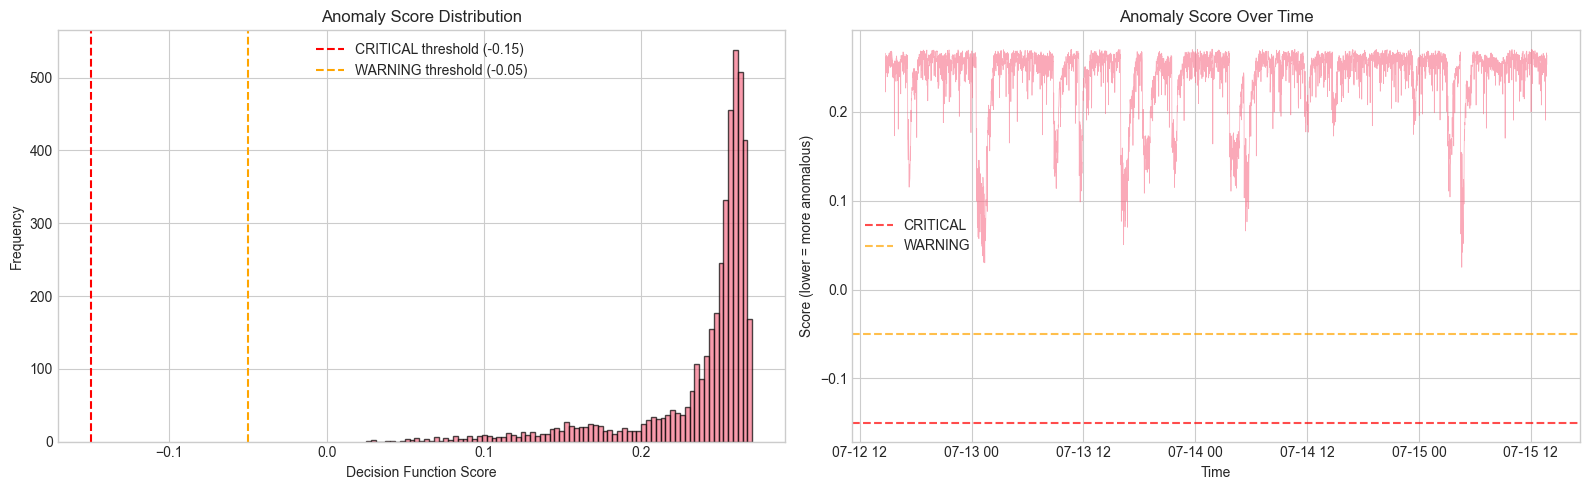

CRITICAL: 0 (0.0%)
NORMAL:   4260 (100.0%)


In [9]:
from sklearn.preprocessing import StandardScaler

# Recompute scores on full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the trained model to score all points
scores = detector._model.decision_function(
    detector._scaler.transform(X)
)
predictions = detector._model.predict(
    detector._scaler.transform(X)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Score histogram
axes[0].hist(scores, bins=80, edgecolor='black', alpha=0.7)
axes[0].axvline(x=-0.15, color='red', linestyle='--', label='CRITICAL threshold (-0.15)')
axes[0].axvline(x=-0.05, color='orange', linestyle='--', label='WARNING threshold (-0.05)')
axes[0].set_title("Anomaly Score Distribution")
axes[0].set_xlabel("Decision Function Score")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Score over time
timestamps = pivoted.index[WINDOW:]
axes[1].plot(timestamps, scores, alpha=0.6, linewidth=0.5)
axes[1].axhline(y=-0.15, color='red', linestyle='--', alpha=0.7, label='CRITICAL')
axes[1].axhline(y=-0.05, color='orange', linestyle='--', alpha=0.7, label='WARNING')
axes[1].set_title("Anomaly Score Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Score (lower = more anomalous)")
axes[1].legend()

plt.tight_layout()
plt.show()

# Summary
n_critical = np.sum(scores < -0.15)
n_warning = np.sum((scores >= -0.15) & (scores < -0.05))
n_normal = np.sum(scores >= -0.05)
print(f"CRITICAL: {n_critical} ({n_critical/len(scores)*100:.1f}%)")
print(f"WARNING:  {n_warning} ({n_warning/len(scores)*100:.1f}%)")
print(f"NORMAL:   {n_normal} ({n_normal/len(scores)*100:.1f}%)")

## 7. Validation: Detect Known Anomalies

Test the model against synthetic anomaly scenarios to validate detection capability.

In [10]:
# Test scenarios
normal_history = history_dicts[100:160]  # 60 minutes of normal data

scenarios = {
    "Normal minute": {"approved": 115, "denied": 5, "failed": 1, "reversed": 1, "backend_reversed": 0, "refunded": 1},
    "Denied spike (3x)": {"approved": 115, "denied": 15, "failed": 1, "reversed": 1, "backend_reversed": 0, "refunded": 1},
    "Denied spike (8x)": {"approved": 115, "denied": 40, "failed": 1, "reversed": 1, "backend_reversed": 0, "refunded": 1},
    "Failed spike (10x)": {"approved": 115, "denied": 5, "failed": 10, "reversed": 1, "backend_reversed": 0, "refunded": 1},
    "Multiple status spike": {"approved": 80, "denied": 30, "failed": 8, "reversed": 6, "backend_reversed": 3, "refunded": 1},
    "Approved crash + denied up": {"approved": 40, "denied": 25, "failed": 5, "reversed": 3, "backend_reversed": 2, "refunded": 1},
}

print(f"{'Scenario':<30} {'Score':>8} {'Severity':<10} {'Anomalous Statuses'}")
print("-" * 80)
for name, counts in scenarios.items():
    result = detector.detect(counts, normal_history)
    anomalous = [a.status for a in result.anomalies if a.is_anomalous]
    print(f"{name:<30} {result.score:>8.4f} {result.severity:<10} {', '.join(anomalous) or '-'}")

Scenario                          Score Severity   Anomalous Statuses
--------------------------------------------------------------------------------
Normal minute                    0.2121 NORMAL     -
Denied spike (3x)                0.1770 WARNING    denied
Denied spike (8x)                0.1065 CRITICAL   denied
Failed spike (10x)               0.1135 CRITICAL   failed
Multiple status spike           -0.0387 CRITICAL   denied, failed, reversed, backend_reversed
Approved crash + denied up       0.0092 CRITICAL   denied, failed, backend_reversed


## 8. Summary

### Model Architecture
- **Algorithm**: Isolation Forest (`sklearn.ensemble.IsolationForest`)
- **Estimators**: 200 trees
- **Contamination**: 2% expected anomaly rate
- **Features**: 46 features per evaluation (per-status counts, ratios, rolling stats, global metrics)
- **Scaling**: StandardScaler applied before scoring

### Severity Mapping
| ML Score Range | Z-Score Override | Severity |
|---|---|---|
| score < -0.15 | max_z > 4.0 | **CRITICAL** |
| -0.15 ≤ score < -0.05 | max_z > 2.5 | **WARNING** |
| score ≥ -0.05 | — | NORMAL |

### Alert Statuses Monitored
- `denied` — transaction denied by authorizer
- `failed` — technical/system failure
- `reversed` — post-authorization reversal
- `backend_reversed` — backend-initiated reversal

### Integration
The serialized model at `artifacts/isolation_forest.joblib` is loaded by the monitoring API's
`AnomalyDetector` class. On each Kafka batch consumption, the detector evaluates the latest
minute's status counts against a rolling 60-minute history window, producing a severity grade
and per-status anomaly details that drive Prometheus metrics and webhook alerts.